In [205]:
""" imports """

import math
import numpy as np
import random
import itertools
import copy
import pandas as pd
import time
from sklearn import datasets
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

In [257]:
""" constants """

MAX_TIME = 300

# Data Structure for POIS and Lists Initialization

In [63]:
""" Class representing a POI """

class POI:
    
    def __init__(self, name, lat, lng, flashtrip_rate, duration_time_estimated):
        self.name = name
        self.lat = lat
        self.lng = lng
        self.flashtrip_rate = flashtrip_rate
        self.duration_time_estimated = duration_time_estimated
        self.cluster = None
        
    def __str__(self):
        return f"POI: {self.name}, with flashtrip_rate: {self.flashtrip_rate} and duration_time_estimated: {self.duration_time_estimated}."
        
        

In [254]:
def create_bcnpois_list():
    
    """ Loading csv in a pandas DataFrame and creating lists """

    df_bcn = pd.read_csv("bcn_pois.csv")
    df_denver = pd.read_csv("denver_pois.csv")

    min_df_bcn = pd.DataFrame({"name":df_bcn["name"], "flashtrip_rate": df_bcn["flashtrip_rate"], "lat":df_bcn["lat"], "lng":df_bcn["lng"],
                  "duration_time_estimated":df_bcn["duration_time_estimated"]})

    pois_bcn = []

    dec = 100
    
    min_df_bcn = min_df_bcn.sort_values('flashtrip_rate', ascending=False)
    
    for index, row in min_df_bcn.iterrows():
        # We simulate FT rate
        dec =  round(dec - 2, 2)
        if dec < 0:
            dec = 0
            
        # We change the duration times of those POIS with 0 minuts (fixing bug)
        if row['duration_time_estimated'] == 0:
            time = 60
        else:
            time = row['duration_time_estimated']
        
        if row['lng'] > 2 and row['name'] != "Gaudí's Crypt": 
            pois_bcn.append(POI(row['name'], row['lat'], row['lng'], dec, time))
    
    return pois_bcn


In [5]:
def load_bcnpois_timematrix():
    with open('matrix_of_timesbcn.npy', 'rb') as f:
        matrix_of_times = np.load(f)
    
    return matrix_of_times

In [6]:
def create_simulated_poi(name):
    return POI(name, 0, 0, 0, 0)

In [7]:
matrix_of_times = load_bcnpois_timematrix()

In [8]:
def add_simulated_initial_tomatrix(matrix_of_times):
    matrix_of_times = np.pad(matrix_of_times, ((0,1), (0,1)), mode='constant')
    return matrix_of_times
    
def add_simulated_final_tomatrix(matrix_of_times):
    matrix_of_times = np.pad(matrix_of_times, ((0,1), (0,1)), mode='constant')
    
    return matrix_of_times
    

# Helper functions for the algorithm

In [246]:
""" Functions to calculate the total times """

def get_time_two_pois(poi1, poi2):
    
    # Returns the time between to pois by retrieving it from the time matrix
    return matrix_of_times[pois_list.index(poi1), pois_list.index(poi2)]
    
def calculate_total_time(current_map):
    # Calculates the total displacement time of visiting the pois of a route
    displacements_time = sum([get_time_two_pois(current_map[i], current_map[i+1]) for i in range(len(current_map) - 1)])
    # We add the spent time in every poi
    total_time = displacements_time + sum([poi.duration_time_estimated for poi in current_map])
    
    return total_time


""" Functions to remove the candidates below the threshold"""

def calculate_threshold(candidates_list, alpha=0.2):
    
    # The threshold is the 20% of the maximum candidate reward
    # This functions returns the threshold
    max_reward = max(get_rewards_list(candidates_list))
    
    return max_reward * alpha
    
def get_rewards(candidate):
    
    # This function returns the sum of the rewards of the pois in a candidate route
    return sum([poi.flashtrip_rate for poi in candidate])

def get_rewards_list(candidates_list):
    
    # This function returns a list with the rewards associated to each candidate
    candidates_rewards = []
    
    for candidate in candidates_list:
        candidates_rewards.append(get_rewards(candidate))
    
    return candidates_rewards

def get_bad_candidates_indexes(candidates_list, alpha):
    
    #This function returns a list with the indexes of those candidates below the threshold
    bad_candidates_indexes = []
    threshold = calculate_threshold(candidates_list, alpha)
    candidates_rewards = get_rewards_list(candidates_list)
    for i, reward in enumerate(candidates_rewards):
        if reward < threshold:
            bad_candidates_indexes.append(i)
    
    return bad_candidates_indexes


    
    

# Algorithm related functions

In [211]:
""" Algorithm """

def GRASP(pois_list, alpha):
    route = []
    route = construct(pois_list, alpha)
    
    route = local_search(route, pois_list)
    
    print(calculate_total_time(route))
    print(get_rewards(route))
    for poi in route:
        print(poi)
    print("-"*40)
    
    for i in range(len(route) - 1):
        print(f"time = {get_time_two_pois(route[i],route[i+1])}")
        
    return route

In [210]:
""" Construction Stage """

def construct(pois_list, alpha):
    
    candidates_list = []
    candidates_aux = []
    candidates_to_remove = []
    num_of_pois_in_candidates = 3

    # Initializing the first route with the initial and final point and the list of candidates
    current_map = [pois_list[-2], pois_list[-1]]
    candidates_list = create_candidates_list(pois_list, current_map)
    
    while len(candidates_list) != 0:

        # Removing candidates with reward below the threshold
        candidates_to_remove = get_bad_candidates_indexes(candidates_list, alpha)
        
        for i in sorted(candidates_to_remove, reverse=True):
            candidates_list.pop(i)

        # Choosing the new current_map randomly
        current_map = candidates_list[random.randint(0, len(candidates_list) - 1)]

        candidates_list = create_candidates_list(pois_list, current_map)
        
        
        
    return current_map

In [209]:
""" Local Search Stage """

def local_search(route, pois_list):
    
    aux_route = route[:]
    best_position_insert = 0
    best_budget_insert = 999999
    best_position_swap = 0
    best_budget_swap = 999999
    best_reward_swap = 0
    best_reward = get_rewards(route)

    route = two_opt_time(route)
    
    # This gets the non-visted POIS
    non_included_pois = list(set(route) ^ set(pois_list))
    
    non_included_pois.sort(key=lambda x: x.flashtrip_rate, reverse=True)
    
    # We test every non included location to see if after the 2-opt optimization can fit either inserting or swapping
    for poi in non_included_pois:
        for i in range(1, len(route) - 1):
            # Trying to insert
            aux_route.insert(i, poi)
            budget_insert = calculate_total_time(aux_route)
            if budget_insert < MAX_TIME and budget_insert < best_budget_insert:
                best_position_insert = i
                best_budget_insert = budget_insert
                best_reward = get_rewards(aux_route)
            elif best_position_insert == 0:
                aux_route.pop(i)
                # Trying to SWAP
                aux_route[i] = poi
                budget_swap = calculate_total_time(aux_route)
                reward_swap = get_rewards(aux_route)
                if budget_swap < MAX_TIME and reward_swap > best_reward and budget_swap < best_budget_swap:
                    best_position_swap = i
                    best_budget_swap = budget_swap
                    best_reward_swap = reward_swap
            aux_route = route[:]
            
        # Inserting or SWAPING POI
        if best_position_insert != 0:
            route.insert(best_position_insert, poi)
        elif best_position_swap != 0:
            route[best_position_swap] = poi
            
        best_position_insert = 0
        best_budget_insert = 999999
        best_position_swap = 0
        best_budget_swap = 999999
        best_reward_swap = 0
        aux_route = route[:]
        
    return route
    

In [208]:
""" Function that creates the list of candidates"""

def create_candidates_list(pois_list, current_map):
    aux_shorter_time = 9999999999
    aux_shorter_path = []
    candidates_list = [] 
    pois_check_remove = []
    candidates_aux = current_map[:]
    candidate_rewards = 0
    
    current_map_rewards = get_rewards(current_map)
        
    # Last two elements will be the initial and final
    for poi in pois_list[0:-2]:
        if poi not in candidates_aux:
            poi_inserted = poi
            
            # Inserting new poi to try from the list of all the pois
            candidates_aux.insert(1, poi)
            candidates_aux_copy = copy.copy(candidates_aux)
            
            # Segment Remove Stage start!
            if calculate_total_time(candidates_aux) > MAX_TIME:
                pois_check_remove = [poi for poi in candidates_aux[1:-1] if poi is not poi_inserted]
                pois_check_remove_lenght = len(pois_check_remove)
                for _ in range(pois_check_remove_lenght):
                    for poi_to_check in pois_check_remove:
                        
                        # Trying if we improve by removing a POI
                        candidates_aux.remove(poi_to_check)
                        if get_rewards(candidates_aux) < current_map_rewards and 
                        calculate_total_time(candidates_aux) < MAX_TIME:
                            break
                        if get_rewards(candidates_aux) > current_map_rewards and 
                        calculate_total_time(candidates_aux) < MAX_TIME:
                            candidates_list.append(candidates_aux)
                            break
                    candidates_aux = candidates_aux_copy[:]
                    # Removing poi_to_check from the list of pois to check because it's been already checked
                    pois_check_remove.pop(0)    
                return candidates_list
            # Getting a list of the permutations of the central pois (not first not last)
            permutations = list(itertools.permutations(candidates_aux[1:-1]))
            for permutation in permutations:
                # Inserting a permutation inside the list to check the time
                candidates_aux[1:-1] = list(permutation)
                total_time_aux_path = calculate_total_time(candidates_aux)
                if  total_time_aux_path < aux_shorter_time:
                    aux_shorter_time  = total_time_aux_path
                    aux_shorter_path = candidates_aux[:]
            candidates_list.append(aux_shorter_path)
            aux_shorter_time = 999999999
            candidates_aux = current_map[:]
            
        
    return candidates_list

In [14]:
""" Function that performs the two-opt algorithm for time """

def two_opt_time(route):
    
    best = route
    improved = True
    
    while improved:
        improved = False
        for i in range(1, len(route)-2):
            for j in range(i+1, len(route)):
                if j-i == 1:continue # changes nothing, skip then
                new_route = route[:]
                new_route[i:j] = route[j-1:i-1:-1] # this is the 2woptSwap
                if calculate_total_time(new_route) < calculate_total_time(best):
                    best = new_route
                    improved = True
        route = best
    return best


# Testing the algorithm

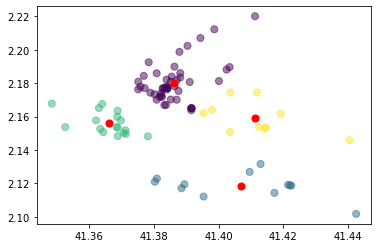

263.0
216
POI: initial, with flashtrip_rate: 0 and duration_time_estimated: 0.
POI: Camp Nou, with flashtrip_rate: 92 and duration_time_estimated: 60.
POI: Tibidabo Amusement Park, with flashtrip_rate: 70 and duration_time_estimated: 60.
POI: Tibidabo, with flashtrip_rate: 54 and duration_time_estimated: 60.
POI: final, with flashtrip_rate: 0 and duration_time_estimated: 0.
----------------------------------------
time = 28.0
time = 27.0
time = 6.0
time = 22.0
257.0
192
POI: initial, with flashtrip_rate: 0 and duration_time_estimated: 0.
POI: Plaça de Catalunya, with flashtrip_rate: 94 and duration_time_estimated: 90.
POI: La Sagrada Familia, with flashtrip_rate: 98 and duration_time_estimated: 120.
POI: final, with flashtrip_rate: 0 and duration_time_estimated: 0.
----------------------------------------
time = 7.0
time = 11.0
time = 29.0
260.0
216
POI: initial, with flashtrip_rate: 0 and duration_time_estimated: 0.
POI: Magic fountain of Montjuic, with flashtrip_rate: 86 and duration

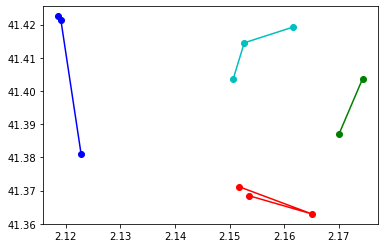

263.0
216
POI: initial, with flashtrip_rate: 0 and duration_time_estimated: 0.
POI: Camp Nou, with flashtrip_rate: 92 and duration_time_estimated: 60.
POI: Tibidabo Amusement Park, with flashtrip_rate: 70 and duration_time_estimated: 60.
POI: Tibidabo, with flashtrip_rate: 54 and duration_time_estimated: 60.
POI: final, with flashtrip_rate: 0 and duration_time_estimated: 0.
----------------------------------------
time = 28.0
time = 27.0
time = 6.0
time = 22.0
297.0
264
POI: initial, with flashtrip_rate: 0 and duration_time_estimated: 0.
POI: Arco de Triunfo de Barcelona, with flashtrip_rate: 78 and duration_time_estimated: 60.
POI: Columbus Monument, Barcelona, with flashtrip_rate: 74 and duration_time_estimated: 60.
POI: Palau de la Música Catalana, with flashtrip_rate: 76 and duration_time_estimated: 60.
POI: Barcelona Museum of Contemporary Art, with flashtrip_rate: 36 and duration_time_estimated: 45.
POI: final, with flashtrip_rate: 0 and duration_time_estimated: 0.
--------------

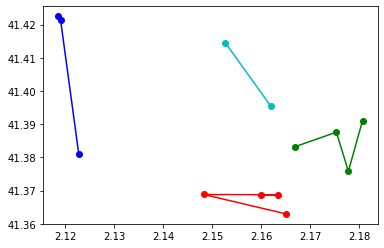

263.0
216
POI: initial, with flashtrip_rate: 0 and duration_time_estimated: 0.
POI: Camp Nou, with flashtrip_rate: 92 and duration_time_estimated: 60.
POI: Tibidabo Amusement Park, with flashtrip_rate: 70 and duration_time_estimated: 60.
POI: Tibidabo, with flashtrip_rate: 54 and duration_time_estimated: 60.
POI: final, with flashtrip_rate: 0 and duration_time_estimated: 0.
----------------------------------------
time = 28.0
time = 27.0
time = 6.0
time = 22.0
257.0
192
POI: initial, with flashtrip_rate: 0 and duration_time_estimated: 0.
POI: Plaça de Catalunya, with flashtrip_rate: 94 and duration_time_estimated: 90.
POI: La Sagrada Familia, with flashtrip_rate: 98 and duration_time_estimated: 120.
POI: final, with flashtrip_rate: 0 and duration_time_estimated: 0.
----------------------------------------
time = 7.0
time = 11.0
time = 29.0
260.0
216
POI: initial, with flashtrip_rate: 0 and duration_time_estimated: 0.
POI: Magic fountain of Montjuic, with flashtrip_rate: 86 and duration

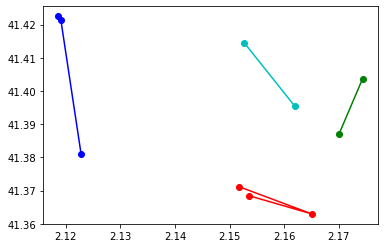

263.0
216
POI: initial, with flashtrip_rate: 0 and duration_time_estimated: 0.
POI: Camp Nou, with flashtrip_rate: 92 and duration_time_estimated: 60.
POI: Tibidabo Amusement Park, with flashtrip_rate: 70 and duration_time_estimated: 60.
POI: Tibidabo, with flashtrip_rate: 54 and duration_time_estimated: 60.
POI: final, with flashtrip_rate: 0 and duration_time_estimated: 0.
----------------------------------------
time = 28.0
time = 27.0
time = 6.0
time = 22.0
257.0
192
POI: initial, with flashtrip_rate: 0 and duration_time_estimated: 0.
POI: Plaça de Catalunya, with flashtrip_rate: 94 and duration_time_estimated: 90.
POI: La Sagrada Familia, with flashtrip_rate: 98 and duration_time_estimated: 120.
POI: final, with flashtrip_rate: 0 and duration_time_estimated: 0.
----------------------------------------
time = 7.0
time = 11.0
time = 29.0
258.0
216
POI: initial, with flashtrip_rate: 0 and duration_time_estimated: 0.
POI: Museu Nacional d'Art de Catalunya, with flashtrip_rate: 62 and d

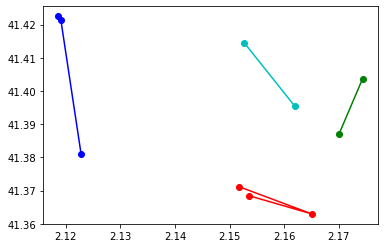

[1076.0, 1147.0, 1071.0, 1069.0] [788, 840, 804, 804] [0.24002909660339355, 0.14707112312316895, 0.133803129196167, 0.12239885330200195]


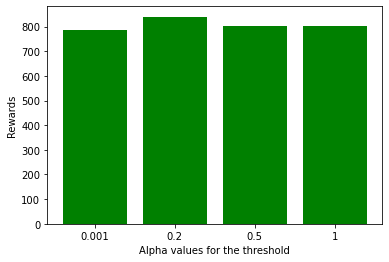

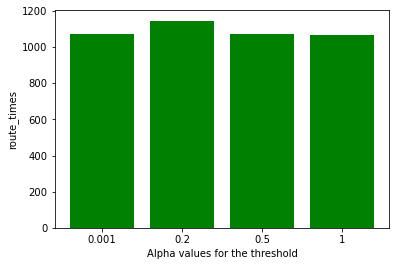

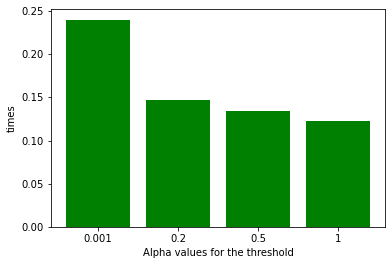

In [258]:
routes = []
route_times = []
rewards = []
route_time = 0
reward = 0
times = []

n_days = 4
matrix_of_times = load_bcnpois_timematrix()
pois_list = create_bcnpois_list()
cluster_for_pois = cluster_city(n_days)

#Assigning each poi to its cluster
for cluster, poi in zip(cluster_for_pois, pois_list):
    poi.cluster = cluster
    

pois_list.append(create_simulated_poi("initial"))
pois_list.append(create_simulated_poi("final"))
matrix_of_times = add_simulated_initial_tomatrix(matrix_of_times)
matrix_of_times = add_simulated_final_tomatrix(matrix_of_times)

for alpha in [0.001, 0.2, 0.5, 1]:
    start = time.time()
    for day in range(n_days):
        day_cluster = [poi for poi in pois_list if (poi.cluster == day or poi.name == "initial" or poi.name == "final")]
        route = GRASP(day_cluster, alpha)
        day_cluster = []
        routes.append(route)
        
        route_time += calculate_total_time(route)
        reward += get_rewards(route)

    draw_route(routes)
    route_times.append(route_time)
    route_time = 0
    rewards.append(reward)
    reward = 0
    routes = []
    day_cluster = []
    times.append(time.time() - start)
    
    
print(route_times, rewards, times)

x = ['0.001', '0.2', '0.5', '1']
values = rewards

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, values, color='green')
plt.xlabel("Alpha values for the threshold")
plt.ylabel("Rewards")

plt.xticks(x_pos, x)

plt.show()

x = ['0.001', '0.2', '0.5', '1']
values = route_times

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, values, color='green')
plt.xlabel("Alpha values for the threshold")
plt.ylabel("route_times")

plt.xticks(x_pos, x)

plt.show()

x = ['0.001', '0.2', '0.5', '1']
values = times

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, values, color='green')
plt.xlabel("Alpha values for the threshold")
plt.ylabel("times")

plt.xticks(x_pos, x)

plt.show()



In [150]:
""" This function makes as many clusters as days in the route, taking into account the location of the POIS """

def cluster_city(n_days):
    pois_list = create_bcnpois_list()
    x = [poi.lat for poi in pois_list]
    y = [poi.lng for poi in pois_list]
    df_dict = {}
    df_dict['x'] = x
    df_dict['y'] = y
    df_coords = pd.DataFrame(df_dict, columns=['x', 'y'])
    
    kmeans = KMeans(n_clusters=n_days).fit(df_coords)
    centroids = kmeans.cluster_centers_
    
    clusters_for_pois = KMeans(n_clusters=n_days).fit_predict(df_coords)

    plt.scatter(df_dict['x'], df_dict['y'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50)
    plt.show()
    
    return clusters_for_pois


In [193]:
""" This function gets a route and draws it """

def draw_route(routes):
    
    
    x_coords = []
    y_coords = []
    colors = ["b", "g", "r", "c", "m", "y", "k"]
    for i, route in enumerate(routes):
        for poi in route[1:-1]:
            x_coords.append(poi.lng)
            y_coords.append(poi.lat)

    #     for i, (x, y) in enumerate(zip(x_coords, y_coords)):
    #         print(x,y)
    #         if i+1 > len(x_coords) - 1:
    #             break
    #         plt.plot([x, y], [x_coords[i+1], y_coords[i+1]])

        plt.plot(x_coords, y_coords, '-o', color=colors[i])
        x_coords = []
        y_coords = []
            
        c = "red"
    plt.show()

In [119]:
print(matrix_of_times[52][55])

for i, poi in enumerate(pois_list):
    print(i, poi)
    


14.0
0 POI: La Sagrada Familia, with flashtrip_rate: 98 and duration_time_estimated: 120.
1 POI: Park Güell, with flashtrip_rate: 96 and duration_time_estimated: 120.
2 POI: Plaça de Catalunya, with flashtrip_rate: 94 and duration_time_estimated: 90.
3 POI: Camp Nou, with flashtrip_rate: 92 and duration_time_estimated: 60.
4 POI: Mercado de La Boqueria, with flashtrip_rate: 90 and duration_time_estimated: 120.
5 POI: Casa Batlló, with flashtrip_rate: 88 and duration_time_estimated: 120.
6 POI: Magic fountain of Montjuic, with flashtrip_rate: 86 and duration_time_estimated: 90.
7 POI: Casa Milà, with flashtrip_rate: 84 and duration_time_estimated: 120.
8 POI: Cathedral of Barcelona, with flashtrip_rate: 82 and duration_time_estimated: 90.
9 POI: Ciutadella Park, with flashtrip_rate: 80 and duration_time_estimated: 90.
10 POI: Arco de Triunfo de Barcelona, with flashtrip_rate: 78 and duration_time_estimated: 60.
11 POI: Palau de la Música Catalana, with flashtrip_rate: 76 and duration_ti

In [102]:
print(pois_list[5].lat, pois_list[5].lng)
print(pois_list[7].lat, pois_list[7].lng)

41.391699999999986 2.1649179999999992
41.39538049999998 2.1619614000000005


In [112]:

import geopy.distance
def getDistanceFromCoordinatesInMeters(lat1, lng1, lat2, lng2):
    
    """
    Attributes:
        lat1, lng1, lat2, lng2: latitudes and longitudes of two positions --> FLOAT / INT
    Return:
         Distance in meters --> FLOAT
    """
    
    distance_in_meters = None
    if is_number(lat1) and is_number(lng1) and is_number(lat2) and is_number(lng2):
        if -90 < lat1 < 90 and -90 < lat1 < 90 and -90 < lat1 < 90 and -90 < lat1 < 90 and -90 < lat1 < 90:
            distance_in_meters = geopy.distance.geodesic(
                (float(lat1), float(lng1)), (float(lat2), float(lng2))).km * 1000
    
    return distance_in_meters

def is_number(s):
    try:
        float(s)
        return True
    except:  # ValueError
        pass
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except:  # (TypeError, ValueError)
        pass
    return False

In [120]:
getDistanceFromCoordinatesInMeters(pois_list[52].lat, pois_list[52].lng, pois_list[55].lat, pois_list[55].lng)

250.66953542183356